<a href="https://colab.research.google.com/github/darren-source/Medical_Transcription/blob/main/Kaggle_Competition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Histopathologic Cancer Detection**

The challenge for this task is to identify metastatic tissue in histopathologic scans of lymph nodes.  The task will be completed by developing an algorithm capable of classifying digital pathological scans as either cancerous or non-cancerous.

The dataset is a modified version of the PatchCamelyon dataset.  The modifications include removal of duplicate images from the original dataset. The data set is called ‘train_labels’ and is a series of pictures labeled as ‘1’ for a cancerous and ‘0’ for non-cancerous.

The datasize contains over 200,000 labeled histopathologic scans.  Although each image is greater than 32x32 pixels, only the central 32X32 pixel region of each picture is used to determine the image label.

A convolutional neural network model will be used to train on the labeled data in order to predict whether unlabeled images are cancerous or non-cancerous.


In [ ]:
# Import file modules from google colab
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"darrencampbell","key":"41e6cf80f0716f19128edcc34be1cf15"}'}

In [ ]:
# Create a directory for the copied files
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
# Use the kaggle API to download the dataset from kaggle competition
!kaggle competitions download -c histopathologic-cancer-detection


100% 6.31G/6.31G [06:11<00:00, 20.9MB/s]
100% 6.31G/6.31G [06:11<00:00, 18.2MB/s]


In [ ]:
# List the files and directories in the currect working directory
!ls

histopathologic-cancer-detection.zip  kaggle.json  sample_data


In [ ]:
# Extract files from a zip archive
!unzip -q histopathologic-cancer-detection.zip

In [ ]:
# Download required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import cv2

In [ ]:
# Explore the dataset
train_labels = pd.read_csv('train_labels.csv')
print(train_labels.shape)
print('---------')
print(train_labels.head())
print('---------')
print(train_labels.info())
print('---------')
print(train_labels.describe())

(220025, 2)
---------
                                         id  label
0  f38a6374c348f90b587e046aac6079959adf3835      0
1  c18f2d887b7ae4f6742ee445113fa1aef383ed77      1
2  755db6279dae599ebb4d39a9123cce439965282d      0
3  bc3f0c64fb968ff4a8bd33af6971ecae77c75e08      0
4  068aba587a4950175d04c680d38943fd488d6a9d      0
---------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 220025 entries, 0 to 220024
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   id      220025 non-null  object
 1   label   220025 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 3.4+ MB
None
---------
               label
count  220025.000000
mean        0.405031
std         0.490899
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max         1.000000


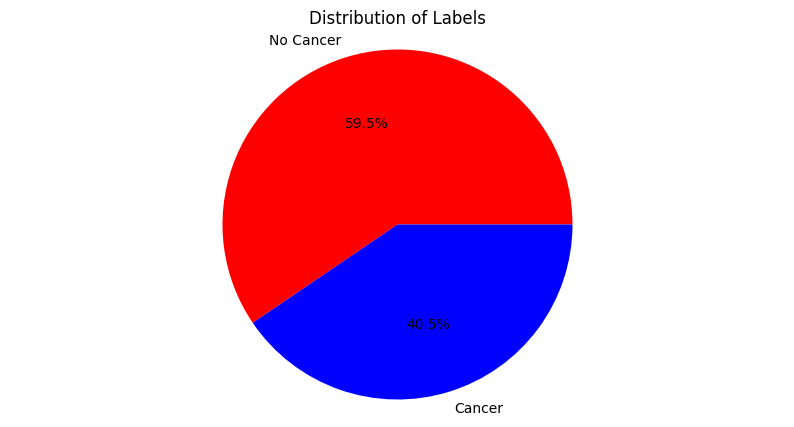

In [ ]:
# Create and display the distribution of labels using a pie chart
label_count = train_labels['label'].value_counts()
colors = ['red', 'blue']
plt.figure(figsize=(10,5))
plt.pie(label_count, labels=['No Cancer', 'Cancer'], colors=colors, autopct='%1.1f%%')
plt.title('Distribution of Labels')
plt.axis('equal')
plt.show()

In [ ]:
# Check for any missing values
print(train_labels.isnull().sum())

id       0
label    0
dtype: int64


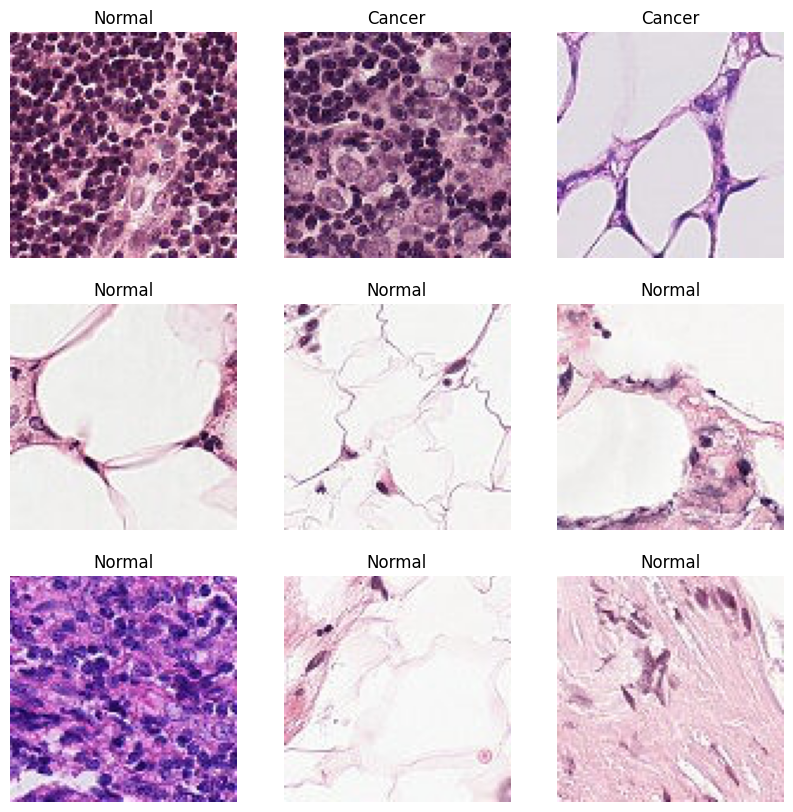

In [ ]:
# Display sample images in a 3X3 grid, swap the image color from BGR to RGB format to insure correct color mapping
def display_image(images, labels):
    plt.figure(figsize=(10,10))
    for i in range(9):
      plt.subplot(3,3,i+1)
      img = cv2.imread(f'train/{images[i]}.tif')
      img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
      plt.imshow(img)
      plt.title('Cancer' if labels[i] == 1 else 'Normal')
      plt.axis('off')
    plt.show()

sample_images = train_labels.sample(n=9)
display_image(sample_images['id'].values, sample_images['label'].values)

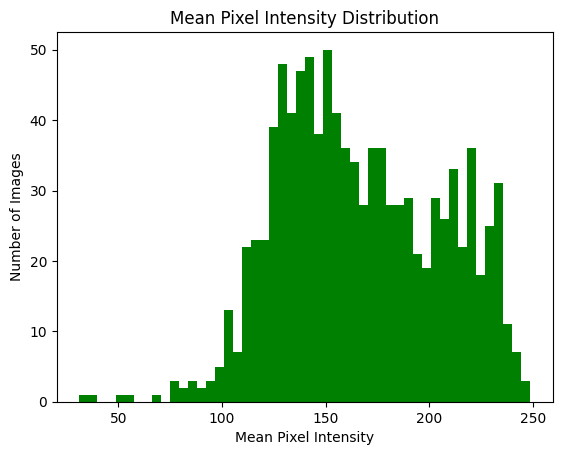

In [ ]:
# Compute the mean pixel intensity ofr the first 1000 photos
from PIL import Image
mean_pixel_values = []

image_dir = 'train/'
for img_name in os.listdir(image_dir)[:1000]:
    img = Image.open(os.path.join(image_dir, img_name))
    img_array = np.array(img)
    mean_pixel_values.append(img_array.mean())

plt.hist(mean_pixel_values, bins=50, color='green')
plt.title('Mean Pixel Intensity Distribution')
plt.xlabel('Mean Pixel Intensity')
plt.ylabel('Number of Images')
plt.show()

In [ ]:
# Import essential modules from TensorFlow for training and building CNN
from tensorflow import keras
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping


In [ ]:
# Append tiff to image files and convert labels to a string to be processed into image generator
train_labels['id'] = train_labels['id'].apply(lambda x: f"{x}.tif")
train_labels['label'] = train_labels['label'].astype(str)

# Rescale images and split data into 80% trainig and 20% validation
datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

In [ ]:
# Read images, resize images to 96X96 pixels, process images in batches
train_generator = datagen.flow_from_dataframe(
    dataframe=train_labels,
    directory='train/',
    x_col='id',
    y_col='label',
    subset='training',
    batch_size=32,
    shuffle=True,
    class_mode='binary',
    target_size=(96, 96)
)

validation_generator = datagen.flow_from_dataframe(
    dataframe=train_labels,
    directory='train/',
    x_col='id',
    y_col='label',
    subset='validation',
    batch_size=32,
    shuffle=True,
    class_mode='binary',
    target_size=(96, 96)
)


Found 176020 validated image filenames belonging to 2 classes.
Found 44005 validated image filenames belonging to 2 classes.


**Model Architecture Explanation**

1. Input Layer
    The model starts with an input shape of 96 X 96 X 3 which is suitable for color images.
2. Convolutional Layers
    32 filters of size 3 x 3. The first convolutional layer captures edge and simple features
    64 filters of size 3 x 3. The second convolutional layer captures more in depth features.
    128 filters of size 3 x 3. The third convolutional layer captures the most complex features
3. MaxPooling Layers
    The max pooling layer with a pool size of 2 x 2.  This will reduce the spatial dimensions of the feature map.
4. Flatten Layers
    Flattening reduces a 2D feature map into a 1D feature map, this makes it suitable for a dense layer.
5. Dense Layers
    512 neurons are used to extract features for the final output.  A dropout is used to prevent overfitting.
6.Output Layers
    1 neuron with sigmoid activation.  This is a binary classification problem, a single neuron is used to create probability likelihood output.  






In [ ]:
# 3 layer convolutional neural network
inputs = Input(shape=(96, 96, 3))
x = Conv2D(32, (3, 3), activation='relu')(inputs)
x = MaxPooling2D(2, 2)(x)
x = Conv2D(64, (3, 3), activation='relu')(x)
x = MaxPooling2D(2, 2)(x)
x = Conv2D(128, (3, 3), activation='relu')(x)
x = MaxPooling2D(2, 2)(x)
x = Flatten()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
outputs = Dense(1, activation='sigmoid')(x)

model = keras.Model(inputs=inputs, outputs=outputs)

model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])
history = model.fit(train_generator, epochs=10, validation_data=validation_generator)

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


5501/5501 ━━━━━━━━━━━━━━━━━━━━ 167s 29ms/step - accuracy: 0.7783 - loss: 0.4733 - val_accuracy: 0.8573 - val_loss: 0.3321
Epoch 2/10
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 154s 28ms/step - accuracy: 0.8600 - loss: 0.3317 - val_accuracy: 0.8819 - val_loss: 0.2882
Epoch 3/10
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 153s 28ms/step - accuracy: 0.8785 - loss: 0.2904 - val_accuracy: 0.8787 - val_loss: 0.2892
Epoch 4/10
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 154s 28ms/step - accuracy: 0.8882 - loss: 0.2703 - val_accuracy: 0.8914 - val_loss: 0.2677
Epoch 5/10
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 153s 28ms/step - accuracy: 0.8961 - loss: 0.2538 - val_accuracy: 0.8997 - val_loss: 0.2519
Epoch 6/10
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 154s 28ms/step - accuracy: 0.9040 - loss: 0.2369 - val_accuracy: 0.8992 - val_loss: 0.2574
Epoch 7/10
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 154s 28ms/step - accuracy: 0.9109 - loss: 0.2249 - val_accuracy: 0.8970 - val_loss: 0.2544
Epoch 8/10
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 153s 28ms/step - accuracy: 0.9154 - lo

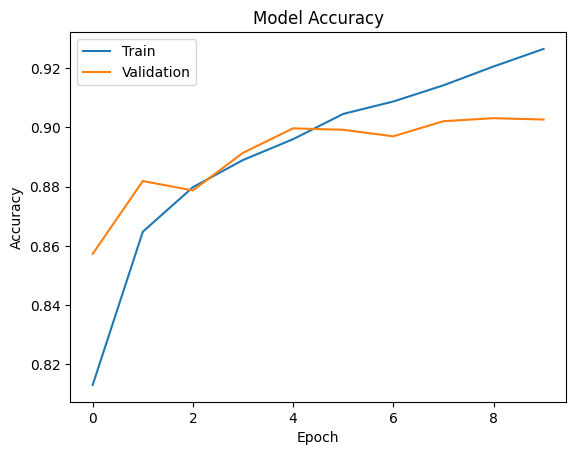

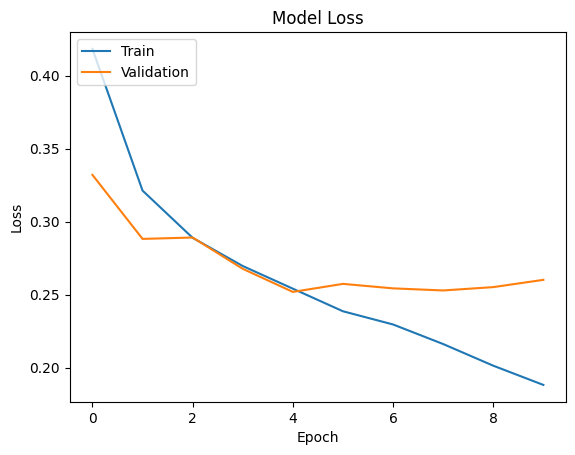

In [ ]:
# Plot the training vs Validation accuracy over epochs
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# plot the training vs validation loss over epochs
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


In [ ]:
# Evaluate the trained model on the validation data set
test_loss, test_accuracy = model.evaluate(validation_generator, steps=validation_generator.samples // validation_generator.batch_size)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

1375/1375 ━━━━━━━━━━━━━━━━━━━━ 31s 22ms/step - accuracy: 0.9046 - loss: 0.2517
Test Loss: 0.26007145643234253
Test Accuracy: 0.9026591181755066


**Improved Model Architecture**

1. Increase Depth
    Add more convolutional layers.  This may make the model more complex but it can cause overfitting.
2. Add Batch Normalization
    Adding batch normalization reduces the problem of vanishing gradients on deeper neural networks.
3. Increase Dropout
    Randomly dropping out neurons during training prevents co-adapting.  This makes the model less sensitive to specific patterns and allows the model to generalize.
4. Increase Epochs
    Extending the training may result in better models but it also increases the risk of over fitting.


In [ ]:
# 4 layer convolutional neural network with Batch Normalization and Dropout
inputs = Input(shape=(96, 96, 3))
x = Conv2D(32, (3, 3), activation='relu')(inputs)
x = BatchNormalization()(x)
x = MaxPooling2D(2, 2)(x)
x = Dropout(0.25)(x)

x = Conv2D(64, (3, 3), activation='relu')(x)
x = BatchNormalization()(x)
x = MaxPooling2D(2, 2)(x)
x = Dropout(0.25)(x)

x = Conv2D(128, (3, 3), activation='relu')(x)
x = BatchNormalization()(x)
x = MaxPooling2D(2, 2)(x)
x = Dropout(0.25)(x)

x = Conv2D(256, (3, 3), activation='relu')(x)
x = BatchNormalization()(x)
x = MaxPooling2D(2, 2)(x)
x = Dropout(0.25)(x)

x = Flatten()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
outputs = Dense(1, activation='sigmoid')(x)

model = keras.Model(inputs=inputs, outputs=outputs)

model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])
history2 = model.fit(train_generator, epochs=12, validation_data=validation_generator)

Epoch 1/12
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 173s 30ms/step - accuracy: 0.8054 - loss: 0.5190 - val_accuracy: 0.8271 - val_loss: 0.4003
Epoch 2/12
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 155s 28ms/step - accuracy: 0.8638 - loss: 0.3323 - val_accuracy: 0.8650 - val_loss: 0.3247
Epoch 3/12
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 156s 28ms/step - accuracy: 0.8823 - loss: 0.2923 - val_accuracy: 0.8940 - val_loss: 0.2793
Epoch 4/12
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 157s 28ms/step - accuracy: 0.8993 - loss: 0.2590 - val_accuracy: 0.8748 - val_loss: 0.2909
Epoch 5/12
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 156s 28ms/step - accuracy: 0.9081 - loss: 0.2388 - val_accuracy: 0.8697 - val_loss: 0.3508
Epoch 6/12
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 156s 28ms/step - accuracy: 0.9129 - loss: 0.2248 - val_accuracy: 0.8675 - val_loss: 0.4185
Epoch 7/12
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 155s 28ms/step - accuracy: 0.9182 - loss: 0.2135 - val_accuracy: 0.9100 - val_loss: 0.3125
Epoch 8/12
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 155s 28ms/step - accuracy: 

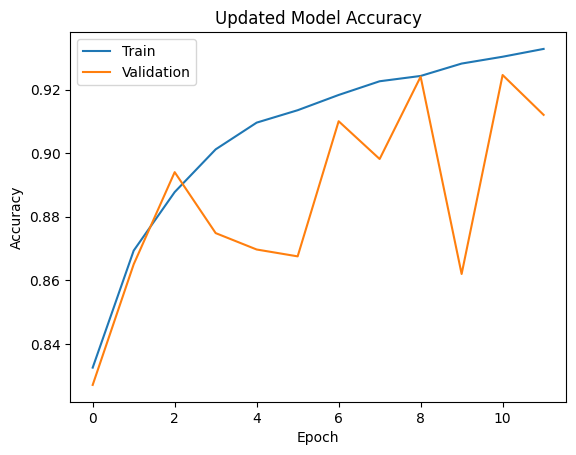

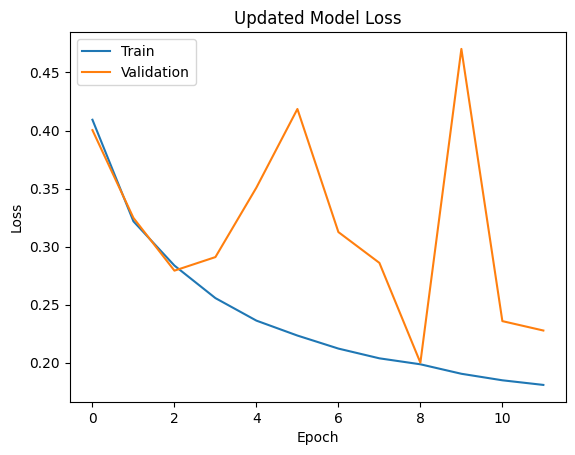

In [ ]:
# Plot the training vs Validation accuracy over epochs
plt.plot(history2.history['accuracy'])
plt.plot(history2.history['val_accuracy'])
plt.title('Updated Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# plot the training vs validation loss over epochs
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('Updated Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [ ]:
# Evaluate the trained model on the validation data set
test_loss, test_accuracy = model.evaluate(validation_generator, steps=validation_generator.samples // validation_generator.batch_size)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

1375/1375 ━━━━━━━━━━━━━━━━━━━━ 32s 23ms/step - accuracy: 0.9126 - loss: 0.2239
Test Loss: 0.22769179940223694
Test Accuracy: 0.9120227098464966


In [ ]:
data = {
    "Model": [1, 2],
    "Training Accuracy": [90.46, 91.26],
    "Training Loss": [0.2517, 0.2239],
    "Test Loss": [0.2601, 0.2277],
    "Test Accuracy": [90.27, 91.20]
}

df = pd.DataFrame(data)
df.set_index('Model', inplace=True)
print(df)

       Training Accuracy  Training Loss  Test Loss  Test Accuracy
Model                                                            
1                  90.46         0.2517     0.2601          90.27
2                  91.26         0.2239     0.2277          91.20


**Conclusion**

Training Accuracy and Loss.  
Model 2 shows a higher training accuracy and lower training loss compared to model 1 on both the training and testing datasets.  The smaller difference (very small difference) between the training and testing metrics of Models suggests that model 2 generalizes better than model 1.

It appears that the improved model architecture features of model 2 improved its performance.  Adding more convolutional layers, introducing batch normalization and changing drop-out rates appears to have improved Model 2's accuracy.  Using techniques like dropout and batch normalization have minimized overfitting and have improved generalization.

The future improvements would be leveraging pre-trained models such as VGG12 and ResNet as a starting point and then using my data to fine tune the model.  Data augmentation techniques may help my model become more robust and prevent over fitting.  The ensemble method of combining multiple models might improve my model performance by capturing different aspects of the data.

The improved performance of model 2 suggest that the chosen model hyperparameter changes were beneficial to the model's performance.
